# Change in labor capacity

Total labour capacity loss by adjusting by fractions of the working population in each sector



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from scipy.special import erf

from tqdm.notebook import tqdm
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC


In [3]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [4]:
MAX_YEAR = 2019
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/labour').absolute()
RESULTS_FOLDER.mkdir(exist_ok=True)

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'


In [5]:
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'labour_capacity'
# INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

In [6]:

MAP_PROJECTION = ccrs.EckertIII()

## Open countries datasets

In [7]:
COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'


In [8]:
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

In [9]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')
COUNTRIES_LOOKUP.NAME0 = COUNTRIES_LOOKUP.NAME0.str.lower()

In [10]:
land_mask  = (COUNTRIES_RASTER.country_codes < 1000)

# Open the generated datasets and combine

affected population for sector = population * working age fraction * fraction in sector

hours lost for sector = hours lost for power corresponding to sector * affector population for sector

hours lost total = sum of hours lost per sector across all sectors

### Assignment of sectors to work power levels

Once you have the cells proportioned between agriculture, industrial and service then you need to assign work loads to these sectors.  Clearly service sector would (on average) be about 200W and would be on average 300W with some areas (such as construction) going up to 400W, but other areas of industry (maybe clothing manufacture) being near 200W.  Agriculture is a problem, because some of this will be in the sun – which we haven’t quite got refined,  Some will be at 400W (hard work such as digging) while other work might be much less than this (berry or grape picking).  We use 400W in the shade as a ball-park average.


For a first approach, use the following simplified power assignement:


| Sector   | Power (W) |
|----------|-----------|
| Service  | 200       |
| Industry | 300       |
| Agri.    | 400       |
| Construction | 400   |
| Manufacturing | 300 |

In [11]:
# Implement a table using the names from the ILO stat db

activity_level = {
    'ECO_SECTOR_AGR' : 400,
    'ECO_AGGREGATE_CON': 400,
    'ECO_AGGREGATE_MAN': 300,
    'ECO_SECTOR_IND':300,
    'ECO_SECTOR_SER': 200
}


In [12]:
# hours_lost = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity'/ 'loss_hours_era5_2019_method' / '*_loss_hours.nc'), 
#                                combine='by_coords')

# hours_lost = hours_lost.groupby('time.year').sum(dim='time')
# hours_lost = hours_lost.drop(['surface', 'number', 'step'])
# hours_lost.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'year_sum_loss_hours.nc')

In [13]:
hours_lost = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'year_sum_loss_hours.nc')

In [14]:
# hours_lost = hours_lost.compute()

In [15]:
hours_lost

<xarray.DataArray 'loss_hours' (year: 40, power: 3, latitude: 361, longitude: 720)>
[31190400 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * power      (power) int64 200 300 400
  * year       (year) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019

## Load ILO employment data mapped to grid

In [16]:
ilo_stat_fractions = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'era_30min_pcts' / 'ilo_fractions_countries.nc')

## Open population/demographic data

In [21]:
# population = xr.open_dataarray(POPULATION_FILE)
# demographics_pct = xr.open_dataset(POP_DATA_SRC / 'demographics_pct_1950_2050.nc')

# pct_pop_working_age = demographics_pct.sel(age_band_lower_bound=slice(15, 65)).sum(dim='age_band_lower_bound')

In [18]:
demographics = xr.open_dataarray(POP_DATA_SRC / 'demographics_1950_2050.nc')

population_working_age = demographics.sel(age_band_lower_bound=slice(15,65)).sum(dim='age_band_lower_bound')

## Calculate the employment rate by combining the ILO data with the population data

Calculate:

*The fraction of working age population who are employed*

In [19]:
ilo_stat_xr = xr.open_dataarray(DATA_SRC / 'lancet' /'labour_capacity' / 'ilo_EMP_2EMP_SEX_ECO_NB.nc')

In [22]:
pop = []

for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_pop = (country_mask * population_working_age).sum(dim=['latitude', 'longitude'])
    country_pop = country_pop.expand_dims(dim={'country':[row.ISOCODE]})
    pop.append(country_pop)

pop = xr.concat(pop, dim='country')

# Percent employment as the total by sector over the population
frac_in_employment = 1000*ilo_stat_xr.sel(classif1='ECO_SECTOR_TOTAL', drop=True) / pop

In [54]:
# Generate country masks
countries = []
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_mask = country_mask.expand_dims(dim={'country':[row.ISOCODE]})
    countries.append(country_mask)

countries = xr.concat(countries, dim='country')

In [55]:
frac_in_employment = (frac_in_employment * countries).sum(dim='country')

In [45]:
f"{ilo_stat_xr.sel(classif1='ECO_SECTOR_TOTAL', year=2019).sum().item()*1000:.3g}"

'3.29e+09'

In [34]:
# IMPAORTANT to time by 1000 cus the values are in thousands...
f"{ilo_stat_xr.sel(classif1='ECO_SECTOR_SER', year=2019).sum().item()*1000:.3g}"

'1.65e+09'

In [58]:
f"{(ilo_stat_fractions.sel(classif1='ECO_SECTOR_SER') * population_working_age *frac_in_employment).sel(year=2019).sum().item():.3g}"

'1.65e+09'

# Calculate the loss hours using population data

factor in that not all people work! So need to futher scale by the fraction of total employed to total persons.

Gridded total pop per sector = population * fraction of population of working age * fraction of working age population in employment


In [59]:
loss_for_sector = []
for sector, power_level in activity_level.items():
    pop_in_sector = ilo_stat_fractions.sel(classif1=sector) * frac_in_employment * population_working_age
    losses = hours_lost.sel(power=power_level, drop=True) * pop_in_sector
    loss_for_sector.append(losses)
    
loss_for_sector = xr.concat(loss_for_sector, dim='classif1')

In [60]:
loss_for_sector

<xarray.DataArray (classif1: 5, year: 29, latitude: 290, longitude: 720)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],


In [61]:
total_loss_sectors = loss_for_sector.sum(dim=['latitude', 'longitude']).compute()

In [62]:
total_loss_sectors = total_loss_sectors.to_dataframe('total_loss_hours').total_loss_hours.unstack().T

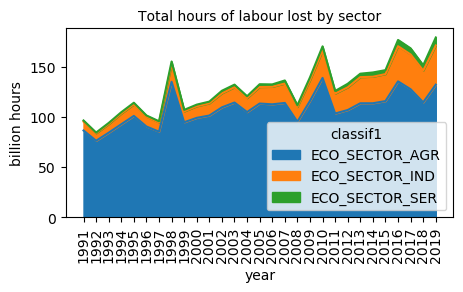

In [63]:
t = total_loss_sectors / 1_000_000_000
# t.columns = t.columns.str.capitalize()

ax = t[['ECO_SECTOR_AGR', 'ECO_SECTOR_IND', 'ECO_SECTOR_SER']].plot.area()
ax.set(ylabel='billion hours',
       title='Total hours of labour lost by sector'
      )

plt.xticks(t.index, rotation=90);
# plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.png', bbox_inches='tight', dpi=300)
# plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.pdf', bbox_inches='tight')

In [64]:
total_loss_sectors.to_excel(RESULTS_FOLDER / 'loss_hours_results_multi_sector.xlsx')

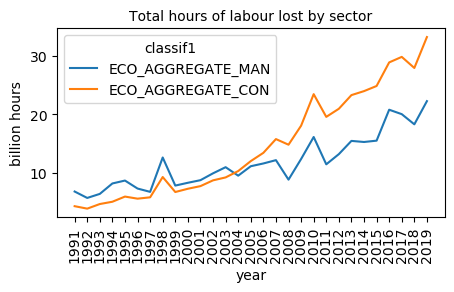

In [65]:
t = total_loss_sectors / 1_000_000_000
# t.columns = t.columns.str.capitalize()

ax = t[['ECO_AGGREGATE_MAN', 'ECO_AGGREGATE_CON']].plot()
ax.set(ylabel='billion hours',
       title='Total hours of labour lost by sector'
      )

plt.xticks(t.index, rotation=90);
plt.savefig(RESULTS_FOLDER / 'loss_hours_manufacutring_construct.png')
# plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.pdf', bbox_inches='tight')

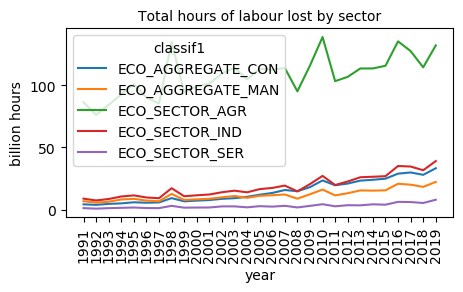

In [66]:
t = total_loss_sectors / 1_000_000_000
# t.columns = t.columns.str.capitalize()

ax = t.plot()
ax.set(ylabel='billion hours',
       title='Total hours of labour lost by sector'
      )

plt.xticks(t.index, rotation=90);
plt.savefig(RESULTS_FOLDER / 'loss_hours_sectors.png')
# plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.pdf', bbox_inches='tight')

# Compare to old method the timeseries trend
Read previously saved results and plot

In [79]:
# total_loss_sectors = pd.read_excel(RESULTS_FOLDER / 'loss_hours_results_multi_sector.xlsx').set_index('year')

In [68]:
total_loss_sectors_old = pd.read_excel(RESULTS_FOLDER/'total loss across sectors.xlsx').set_index('year')

In [69]:
100*(total_loss_sectors.ECO_SECTOR_SER - total_loss_sectors_old.service) / total_loss_sectors_old.service

year
1991         NaN
1992         NaN
1993         NaN
1994         NaN
1995         NaN
1996         NaN
1997         NaN
1998         NaN
1999         NaN
2000    2.023980
2001    4.564099
2002   -0.026989
2003   -1.478120
2004   -0.000110
2005   -1.648243
2006   -2.333958
2007   -2.998077
2008   -1.003004
2009   -2.219911
2010   -4.672438
2011   -2.591375
2012   -3.624725
2013   -4.742737
2014   -5.638670
2015   -5.663116
2016   -7.785305
2017   -7.572368
2018   -6.991718
2019   -9.781892
dtype: float64